## 자전거 & 오토바이 이미지 분류 모델

In [1]:
!pip install -Uqq fastai duckduckgo_search nbdev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.2 MB/s eta 0:00:00


In [3]:
from fastcore.all import *
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastdownload import download_url
from duckduckgo_search import DDGS

from itertools import islice
from time import sleep

In [11]:
searchs = ['bicycle', 'motorcycle']

path = Path('vehicles')

In [7]:
def search_images(term, max_images=40):
    print(f"Searching for '{term}'")
    ddgs_images = DDGS().images(
        term,
        type_image="photo",
        license_image="Public"
    )

    limited_images = list(islice(ddgs_images, max_images))
    return L(limited_images).itemgot('image')

Searching for 'bicycle'


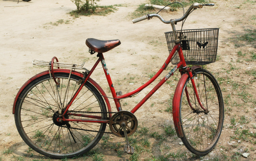

Searching for 'motorcycle'


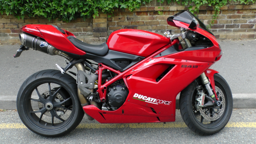

In [8]:
for o in searchs:
    urls = search_images(o, max_images=1)
    dest = f"{o}.jpg"
    download_url(urls[0], dest, show_progress=False)
    im= Image.open(dest)
    display(im.to_thumb(256))

#### Download Data

In [12]:
for o in searchs:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)

    download_images(dest, urls=search_images(f"{o}"))
    sleep(10)

    download_images(dest, urls=search_images(f"{o} in the park"))
    sleep(10)

    download_images(dest, urls=search_images(f"{o} on the road"))
    sleep(10)

    resize_images(dest, max_size=400, dest=dest)

Searching for 'bicycle'
Searching for 'bicycle in the park'
Searching for 'bicycle on the road'
Searching for 'motorcycle'
Searching for 'motorcycle in the park'
Searching for 'motorcycle on the road'


In [13]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

#### 모델 학습

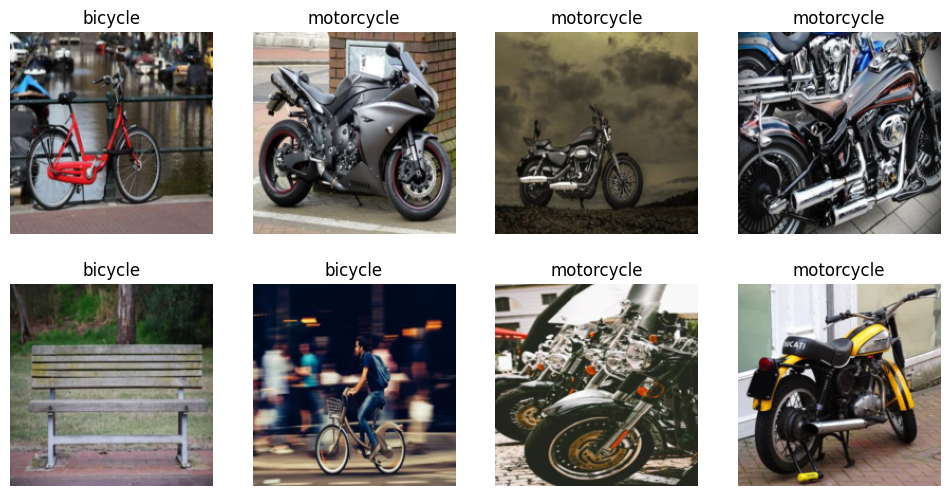

In [16]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=8)

In [17]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 55.3MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.408693,0.870239,0.461538,00:24


epoch,train_loss,valid_loss,error_rate,time
0,0.625277,0.473822,0.179487,00:41
1,0.452406,0.528807,0.128205,00:44
2,0.368513,0.597526,0.179487,00:45
3,0.304220,0.626001,0.153846,00:49
4,0.246475,0.615400,0.179487,00:49


#### Inference

prediction: bicycle
probability: 0.9998


<Axes: >

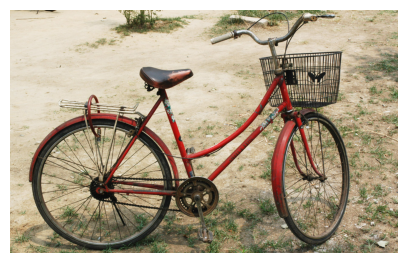

In [18]:
im = PILImage.create('bicycle.jpg')

pred, pred_idx, probs = learn.predict(im)

print(f"prediction: {pred}")
print(f"probability: {probs[pred_idx]:.04f}")

im.show()

prediction: motorcycle
probability: 0.9985


<Axes: >

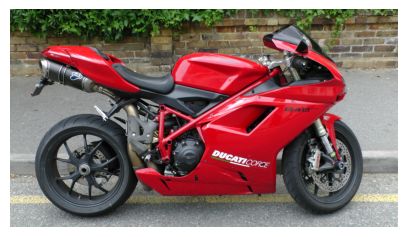

In [19]:
im = PILImage.create('motorcycle.jpg')

pred, pred_idx, probs = learn.predict(im)

print(f"prediction: {pred}")
print(f"probability: {probs[pred_idx]:.04f}")

im.show()

#### Widget

In [20]:
btn_upload = widgets.FileUpload(
    accept='image/*',
    multiple=False
)

btn_run = widgets.Button(description='Classify')
out_pl = widgets.Output()
lbl_pred = widgets.Label()

In [21]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(256, 256))
    pred, pred_idx, probs = learn.predict(img)
    lbl_pred.value = f"pred:{pred}; prob:{probs[pred_idx]:.04f}"

btn_run.on_click(on_click_classify)

In [22]:
VBox([widgets.Label("bicycle or motorcycle?"), btn_upload, btn_run, out_pl, lbl_pred])